# Project AKT3 - Cat Breed Classification

Classifies cat breeds using a dataset from kaggle (https://www.kaggle.com/ma7555/cat-breeds-dataset)

Experiments with 3 models
* custom CNN
* Transfer learning using InceptionV3 + additional layers
* Transfer learning using InceptionResNetV2 + additional layers

The third model works best. It could be even improved with longer training time.

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, shutil
import random
import sys

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import glob
from PIL import Image, ImageFile

from tqdm.auto import tqdm

In [3]:
base_dir = '/content/drive/My Drive/Colab Notebooks/'
sys.path.append(base_dir)
tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/Colab Notebooks/'

# Download Dataset from Kaggle

In [ ]:
!cd "$base_dir"; kaggle datasets download -d ma7555/cat-breeds-dataset

 99% 1.92G/1.93G [00:44<00:00, 65.6MB/s]
100% 1.93G/1.93G [00:44<00:00, 46.6MB/s]


In [ ]:
!pwd; ls -l

/content
total 8
drwx------ 5 root root 4096 Nov 29 09:15 drive
drwxr-xr-x 1 root root 4096 Nov 18 14:36 sample_data


## Unzip data to local directory in Colab Runtime

In [5]:
!cd ~; unzip -n '$base_dir/cat-breeds-dataset.zip' >/dev/null

In [ ]:
!cd "$base_dir"; pwd

/content/drive/My Drive/Colab Notebooks


In [ ]:
!ls /root

data  images


# Create test and train folder

In [6]:
train_data_dir = os.path.expanduser('~/cat-breeds/train')
test_data_dir = os.path.expanduser('~/cat-breeds/test')
if not os.path.exists('/root/cat-breeds'):
  os.mkdir('/root/cat-breeds')

if not os.path.exists(train_data_dir):    
  os.mkdir(train_data_dir)

if not os.path.exists(test_data_dir):
  os.mkdir(test_data_dir)

# Helper functions

In [7]:
def evaluate_result(y, pred, classes=None, no_classes=67):
    if classes is not None:
        no_classes = len(classes)
    else:
        classes = [str(i) for i in range(no_classes)]

    if len(pred.shape) == 2:
        predC = np.argmax(pred, axis=1)
    elif len(pred.shape) == 1:
        predC = pred
    else:
        raise('pred has wrong format')
    cfTable = confusion_matrix(y, predC, labels=range(no_classes))
    
    print(cfTable)

    print('\n')
    
    TPRs = pd.Series(0., index=range(no_classes))
    
    for cl in range(no_classes):
        print('Class %s:'%(classes[cl]))
        others = list(set(list(range(cfTable.shape[0]))) - set([cl]))
        tp = cfTable[cl, cl]
        tn = np.sum(cfTable[others, :][:, others])
        fp = np.sum(cfTable[others, :][:, [cl]])
        fn = np.sum(cfTable[[cl], :][:, others])
        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)
        prec = tp / (tp + fp)
        TPRs[cl] = tpr
        print('    Sensitivity (TPR): %7.3f%% (%d of %d)'%(100. * tpr, tp, tp + fn)) 
        print('    Specificity (TNR): %7.3f%% (%d of %d)'%(100. * tnr, tn, tn + fp)) 
        print('    Precision:         %7.3f%% (%d of %d)'%(100. * prec, tp, tp + fp))
        print('    Neg. pred. value:  %7.3f%% (%d of %d)'%(100. * tn / (tn + fn) , tn, tn + fn))
    
    print('\nOverall accuracy:  %7.3f%% (%d of %d)'%(np.sum(np.diagonal(cfTable)) * 100. / len(y),
          np.sum(np.diagonal(cfTable)), len(y)))
    print('Balanced accuracy: %7.3f%%'%(np.mean(TPRs) * 100.))
        
    return(cfTable)

In [8]:
def plot_history(history, measure='accuracy', figsize=(8, 6)):
    plt.figure(figsize=figsize)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training history')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    if measure is not None and measure in history.history.keys() and \
        'val_' + measure in history.history.keys():
        plt.figure(figsize=figsize)
        plt.plot(history.history[measure])
        plt.plot(history.history['val_' + measure])
        plt.title('Training history')
        plt.ylabel(measure)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

# Preprocessing

In [9]:
d = '/root/data/'
src_dir = '/root/images/'
dest_dir = d + 'processed/'
label_df = pd.read_csv(d + 'cats.csv', index_col='id')

## Extract Classes

In [10]:
all_classes = label_df['breed'].unique()
all_classes.sort()
print(all_classes)

['Abyssinian' 'American Bobtail' 'American Curl' 'American Shorthair'
 'American Wirehair' 'Applehead Siamese' 'Balinese' 'Bengal' 'Birman'
 'Bombay' 'British Shorthair' 'Burmese' 'Burmilla' 'Calico'
 'Canadian Hairless' 'Chartreux' 'Chausie' 'Chinchilla' 'Cornish Rex'
 'Cymric' 'Devon Rex' 'Dilute Calico' 'Dilute Tortoiseshell'
 'Domestic Long Hair' 'Domestic Medium Hair' 'Domestic Short Hair'
 'Egyptian Mau' 'Exotic Shorthair' 'Extra-Toes Cat - Hemingway Polydactyl'
 'Havana' 'Himalayan' 'Japanese Bobtail' 'Javanese' 'Korat' 'LaPerm'
 'Maine Coon' 'Manx' 'Munchkin' 'Nebelung' 'Norwegian Forest Cat' 'Ocicat'
 'Oriental Long Hair' 'Oriental Short Hair' 'Oriental Tabby' 'Persian'
 'Pixiebob' 'Ragamuffin' 'Ragdoll' 'Russian Blue' 'Scottish Fold'
 'Selkirk Rex' 'Siamese' 'Siberian' 'Silver' 'Singapura' 'Snowshoe'
 'Somali' 'Sphynx - Hairless Cat' 'Tabby' 'Tiger' 'Tonkinese' 'Torbie'
 'Tortoiseshell' 'Turkish Angora' 'Turkish Van' 'Tuxedo' 'York Chocolate']


## Create test, validation and training set

In [11]:
test_split = 0.2
validation_split = 0.2
train_split = 1 - (test_split + validation_split)

random.seed(4232)

all_samples = list(index for index, value in label_df['Unnamed: 0'].items())
train_samples = random.sample(all_samples, k=round(len(all_samples) * train_split))
other_samples = list(set(all_samples).difference(set(train_samples)))
aux_split = validation_split / (validation_split + test_split)
validation_samples = random.sample(other_samples, k=round(len(other_samples) * aux_split))
test_samples = list(set(other_samples).difference(set(validation_samples)))

train_samples.sort()
validation_samples.sort()
test_samples.sort()

In [12]:
if not os.path.exists(dest_dir):
    os.mkdir(dest_dir)

train_data_dir = dest_dir + 'train/'
validation_data_dir = dest_dir + 'validation/'
test_data_dir = dest_dir + 'test/'

if not os.path.exists(train_data_dir):
    os.mkdir(train_data_dir)
if not os.path.exists(validation_data_dir):
    os.mkdir(validation_data_dir)
if not os.path.exists(test_data_dir):
    os.mkdir(test_data_dir)
    
for cl in all_classes:
    if not os.path.exists(train_data_dir + cl):
        os.mkdir(train_data_dir + cl)
    if not os.path.exists(validation_data_dir + cl):
        os.mkdir(validation_data_dir + cl)
    if not os.path.exists(test_data_dir + cl):
        os.mkdir(test_data_dir + cl)

In [13]:
def get_breed(label_df, sample):
  breed = label_df.loc[sample, 'breed']
  if isinstance(breed, pd.Series): # tuple
    return list(breed)[1]
  else:                            # string
    return breed

for sample in tqdm(train_samples):
  breed = get_breed(label_df, sample)
  
  for file in glob.glob(src_dir + breed + '/' + str(sample) + '*.jpg'):
    shutil.copy(file, dest_dir + 'train/' + breed)

for sample in tqdm(validation_samples):
  breed = get_breed(label_df, sample)

  for file in glob.glob(src_dir + breed + '/' + str(sample) + '*.jpg'):
    shutil.copy(file, dest_dir + 'validation/' + breed)

for sample in tqdm(test_samples):
  breed = get_breed(label_df, sample)

  for file in glob.glob(src_dir + breed + '/' + str(sample) + '*.jpg'):
    shutil.copy(file, dest_dir + 'test/' + breed)

  0%|          | 0/40287 [00:00<?, ?it/s]

  0%|          | 0/13410 [00:00<?, ?it/s]

  0%|          | 0/13410 [00:00<?, ?it/s]

# Configure Generators for first and second model

In [ ]:
batch_size = 64
img_size = (128, 128)

train_datagen = ImageDataGenerator(width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    vertical_flip=False,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(train_data_dir, 
                                                    target_size=img_size, 
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

val_test_datagen = ImageDataGenerator(rescale=(1. / 255))

validation_generator = val_test_datagen.flow_from_directory(validation_data_dir, 
                                                            target_size=img_size, 
                                                            batch_size=batch_size,
                                                            class_mode='categorical')

test_generator = val_test_datagen.flow_from_directory(test_data_dir, 
                                                      target_size=img_size, 
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode='categorical')

Found 40287 images belonging to 67 classes.
Found 13413 images belonging to 67 classes.
Found 13414 images belonging to 67 classes.


# Create Model

In [ ]:
model = tf.keras.models.Sequential([
 tf.keras.layers.Conv2D(32, (3, 3), input_shape=(img_size[0], img_size[1], 3),
 padding='same', activation='relu', use_bias=False),
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.Conv2D(32, (3, 3),
 padding='same', activation='relu', use_bias=False),
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.MaxPooling2D((2, 2)),
 tf.keras.layers.Dropout(0.2),
 tf.keras.layers.Conv2D(64, (3, 3),
 padding='same', activation='relu', use_bias=False),
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.Conv2D(64, (3, 3),
 padding='same', activation='relu', use_bias=False),
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.MaxPooling2D((2, 2)),
 tf.keras.layers.Dropout(0.2),
 tf.keras.layers.Conv2D(128, (3, 3),
 padding='same', activation='relu', use_bias=False),
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.Conv2D(128, (3, 3),
 padding='same', activation='relu', use_bias=False),
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.MaxPooling2D((2, 2)),
 tf.keras.layers.Dropout(0.2),
 tf.keras.layers.Flatten(),
 tf.keras.layers.Dropout(0.2),
 tf.keras.layers.Dense(128, activation='relu', use_bias=False),
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.Dropout(0.2),
 tf.keras.layers.Dense(len(all_classes), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      864       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9216      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                        

# Train Model

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

# trained 15 Epochs, after that Colab startet training again
filepath = '/content/drive/My Drive/Colab Notebooks/models/project_{epoch:02d}-{val_accuracy:.4f}.hdf5'
callbacks_list = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')]
history = model.fit(train_generator,
                    steps_per_epoch=(len(train_generator.filenames) // batch_size), 
                    epochs=15,
                    validation_data=validation_generator, 
                    validation_steps=(len(validation_generator.filenames) // batch_size),
                    callbacks=callbacks_list)

Epoch 1/15
 49/629 [=>............................] - ETA: 4:30 - loss: 2.5128 - accuracy: 0.3061

KeyboardInterrupt: ignored

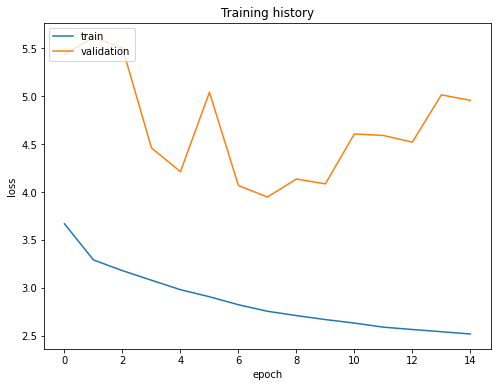

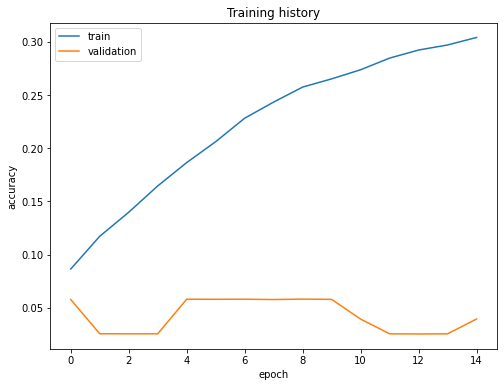

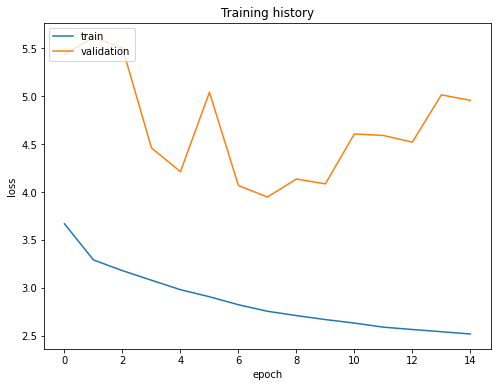

In [ ]:
plot_history(history)        # plot accuracy
plot_history(history, 'mae') # plot loss

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/' + 'model1.hdf5')

# Evaluate on Test Data

In [ ]:
pred = model.predict(test_generator, steps=len(test_generator.filenames))
pred

array([[1.0924083e-03, 4.7493059e-02, 6.4439597e-03, ..., 2.5205789e-03,
        4.6410118e-03, 2.6518434e-05],
       [1.1047105e-03, 4.7360770e-02, 6.4740391e-03, ..., 2.5386617e-03,
        4.6436409e-03, 2.6709096e-05],
       [1.1062175e-03, 4.7374632e-02, 6.4702160e-03, ..., 2.5204432e-03,
        4.7109867e-03, 2.6310385e-05],
       ...,
       [1.0947525e-03, 4.7455341e-02, 6.4428351e-03, ..., 2.5099397e-03,
        4.6404153e-03, 2.6383532e-05],
       [1.1006473e-03, 4.7438681e-02, 6.4552417e-03, ..., 2.5217156e-03,
        4.7113467e-03, 2.6649905e-05],
       [1.0977659e-03, 4.7261242e-02, 6.4271390e-03, ..., 2.5106946e-03,
        4.6662078e-03, 2.5979965e-05]], dtype=float32)

In [ ]:
evaluate_result(test_generator.classes, pred);

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Class 0:
    Sensitivity (TPR):   0.000% (0 of 49)
    Specificity (TNR): 100.000% (13365 of 13365)
    Precision:             nan% (0 of 0)
    Neg. pred. value:   99.635% (13365 of 13414)
Class 1:
    Sensitivity (TPR):   0.000% (0 of 199)
    Specificity (TNR): 100.000% (13215 of 13215)
    Precision:             nan% (0 of 0)
    Neg. pred. value:   98.516% (13215 of 13414)
Class 2:
    Sensitivity (TPR):   0.000% (0 of 35)
    Specificity (TNR): 100.000% (13379 of 13379)
    Precision:             nan% (0 of 0)
    Neg. pred. value:   99.739% (13379 of 13414)
Class 3:
    Sensitivity (TPR):   0.000% (0 of 790)
    Specificity (TNR): 100.000% (12624 of 12624)
    Precision:             nan% (0 of 0)
    Neg. pred. value:   94.111% (12624 of 13414)
Class 4:
    Sensitivity (TPR):   0.000% (0 of 4)
    Specificity (TNR): 100.000% (13410 of 13410)
    Precision:   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


# Try pretrained models

In [ ]:
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
for layer in base_model.layers:
    layer.trainable = False

model2 = tf.keras.models.Sequential()
model2.add(base_model)
model2.add(tf.keras.layers.GlobalAveragePooling2D())
model2.add(tf.keras.layers.Dense(128))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(len(all_classes), activation = 'softmax'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 67)                8643      
                                                                 
Total params: 22,073,699
Trainable params: 270,915
Non-trainable params: 21,802,784
____________________________________

In [ ]:
model2.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.99, nesterov=True), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

history = model2.fit(train_generator,
                     steps_per_epoch=175, 
                     epochs=15,
                     validation_data=validation_generator, 
                     validation_steps=44,
                     callbacks=callbacks_list)

Epoch 1/15
175/175 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0184
Epoch 00001: val_accuracy improved from 0.00320 to 0.00355, saving model to /content/drive/My Drive/Colab Notebooks/models/project_01-0.0036.hdf5
175/175 [==============================] - 94s 510ms/step - loss: nan - accuracy: 0.0184 - val_loss: nan - val_accuracy: 0.0036
Epoch 2/15
175/175 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0036
Epoch 00002: val_accuracy did not improve from 0.00355
175/175 [==============================] - 87s 499ms/step - loss: nan - accuracy: 0.0036 - val_loss: nan - val_accuracy: 0.0025
Epoch 3/15
175/175 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0037
Epoch 00003: val_accuracy did not improve from 0.00355
175/175 [==============================] - 88s 502ms/step - loss: nan - accuracy: 0.0037 - val_loss: nan - val_accuracy: 0.0028
Epoch 4/15
175/175 [==============================] - ETA: 0s - loss: nan - accur

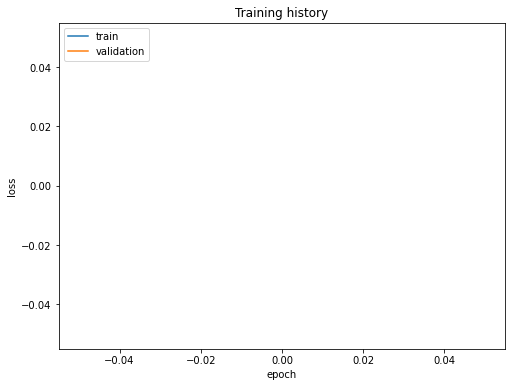

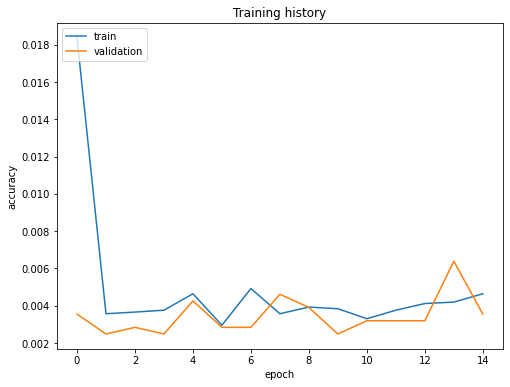

In [ ]:
plot_history(history)

In [ ]:
pred = model2.predict(test_generator, steps=len(test_generator.filenames))
pred

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [ ]:
evaluate_result(test_generator.classes, pred);

[[ 49   0   0 ...   0   0   0]
 [199   0   0 ...   0   0   0]
 [ 35   0   0 ...   0   0   0]
 ...
 [138   0   0 ...   0   0   0]
 [420   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


Class 0:
    Sensitivity (TPR): 100.000% (49 of 49)
    Specificity (TNR):   0.000% (0 of 13365)
    Precision:           0.365% (49 of 13414)
    Neg. pred. value:      nan% (0 of 0)
Class 1:
    Sensitivity (TPR):   0.000% (0 of 199)
    Specificity (TNR): 100.000% (13215 of 13215)
    Precision:             nan% (0 of 0)
    Neg. pred. value:   98.516% (13215 of 13414)
Class 2:
    Sensitivity (TPR):   0.000% (0 of 35)
    Specificity (TNR): 100.000% (13379 of 13379)
    Precision:             nan% (0 of 0)
    Neg. pred. value:   99.739% (13379 of 13414)
Class 3:
    Sensitivity (TPR):   0.000% (0 of 790)
    Specificity (TNR): 100.000% (12624 of 12624)
    Precision:             nan% (0 of 0)
    Neg. pred. value:   94.111% (12624 of 13414)
Class 4:
    Sensitivity (TPR):   0.000% (0 of 4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
model2.save('/content/drive/My Drive/Colab Notebooks/' + 'model2.hdf5')

# Try InceptionResNetV2

In [14]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

inceptionresnetv2 = tf.keras.applications.InceptionResNetV2(weights='imagenet')
inceptionresnetv2_train_data = ImageDataGenerator(rotation_range=20, width_shift_range=0.2,  
                  height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, zoom_range=0.2,
                  preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
inceptionresnetv2_val_data = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

train_generator = inceptionresnetv2_train_data.flow_from_directory(train_data_dir, batch_size=32, target_size=(299,299))
val_generator = inceptionresnetv2_val_data.flow_from_directory(validation_data_dir, batch_size=32, target_size=(299,299))
test_generator =  inceptionresnetv2_val_data.flow_from_directory(test_data_dir, batch_size=32, target_size=(299,299))

headless_inceptionresnetv2 = tf.keras.Model(inputs=[inceptionresnetv2.input], outputs=[inceptionresnetv2.get_layer('avg_pool').output])

model3 = tf.keras.models.Sequential([headless_inceptionresnetv2,
                                     tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.Dropout(0.5),
                                     tf.keras.layers.Dense(len(all_classes), activation='softmax')])

model3.summary()

225222656/225209952 [==============================] - 3s 0us/step
Found 40287 images belonging to 67 classes.
Found 13413 images belonging to 67 classes.
Found 13414 images belonging to 67 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 1536)              54336736  
                                                                 
 batch_normalization_203 (Ba  (None, 1536)             6144      
 tchNormalization)                                               
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 67)                102979    
                                                                 
Total params: 54,445,859
Trainable params: 54,382,243
N

In [ ]:
model3.compile(optimizer=tf.keras.optimizers.SGD(0.01), loss='categorical_crossentropy', metrics=['accuracy'])
history = model3.fit(train_generator, 
                     steps_per_epoch=(len(train_generator.filenames) // batch_size), 
                     validation_data=val_generator, validation_steps=(len(val_generator.filenames) // batch_size),
                     epochs=20, max_queue_size=10, verbose=1,
                     callbacks=callbacks_list)
# stopped by Colab during Epoch 9 - accuracy 41.51 %

## Continue training
Unfortunately Colab kicks you out of the session after a certain time. Therefore we load the best model here and continue training where we left before saving the model

In [16]:
filepath = '/content/drive/My Drive/Colab Notebooks/models/project_{epoch:02d}-{val_accuracy:.4f}.hdf5'
callbacks_list = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')]
batch_size = 64
loaded_model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/models/project_05-0.4151.hdf5')
history = loaded_model.fit(train_generator, 
                           steps_per_epoch=(len(train_generator.filenames) // batch_size), 
                           validation_data=val_generator, validation_steps=(len(val_generator.filenames) // batch_size),
                           epochs=10, max_queue_size=10, verbose=1,
                           callbacks=callbacks_list)

Epoch 1/10
629/629 [==============================] - ETA: 0s - loss: 2.4497 - accuracy: 0.3916
Epoch 00001: val_accuracy improved from -inf to 0.42943, saving model to /content/drive/My Drive/Colab Notebooks/models/project_01-0.4294.hdf5
629/629 [==============================] - 1764s 3s/step - loss: 2.4497 - accuracy: 0.3916 - val_loss: 2.0665 - val_accuracy: 0.4294
Epoch 2/10
629/629 [==============================] - ETA: 0s - loss: 2.3564 - accuracy: 0.4040
Epoch 00002: val_accuracy did not improve from 0.42943
629/629 [==============================] - 1724s 3s/step - loss: 2.3564 - accuracy: 0.4040 - val_loss: 6.5491 - val_accuracy: 0.3837
Epoch 3/10
629/629 [==============================] - ETA: 0s - loss: 2.4272 - accuracy: 0.3886
Epoch 00003: val_accuracy did not improve from 0.42943
629/629 [==============================] - 1723s 3s/step - loss: 2.4272 - accuracy: 0.3886 - val_loss: 4.8881 - val_accuracy: 0.3891
Epoch 4/10
629/629 [==============================] - ETA: 0

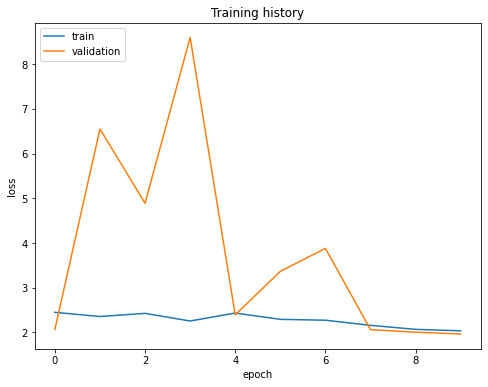

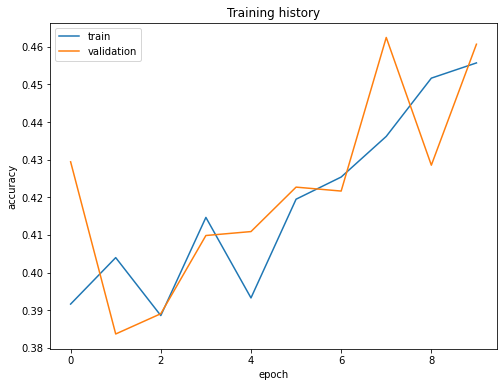

In [17]:
plot_history(history)

In [ ]:
loaded_model.save('/content/drive/My Drive/Colab Notebooks/' + 'model3.hdf5')

## Evaluate on Test Data (best model)

---



In [18]:
best_model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/models/project_08-0.4625.hdf5')
pred = best_model.predict(test_generator, steps=len(test_generator.filenames))
pred

array([[2.78314506e-03, 3.02484049e-03, 9.11091571e-04, ...,
        1.58119670e-04, 1.76716159e-04, 8.42000183e-04],
       [1.87429134e-03, 6.97312783e-03, 1.08222908e-03, ...,
        5.33409882e-04, 3.84604884e-03, 6.15869241e-04],
       [3.54996482e-05, 1.59655756e-04, 5.21197333e-04, ...,
        1.31566415e-03, 1.58071689e-05, 4.26127430e-04],
       ...,
       [9.70353954e-04, 5.01374539e-04, 1.40075135e-04, ...,
        1.39958761e-03, 1.04140476e-04, 2.37158863e-04],
       [1.77249385e-04, 7.61757325e-03, 7.04535609e-03, ...,
        3.35446792e-03, 5.01991366e-04, 5.03418094e-04],
       [7.84604272e-05, 3.83374427e-04, 3.06020112e-04, ...,
        9.16637728e-05, 8.35858737e-05, 1.85106779e-04]], dtype=float32)

In [19]:
evaluate_result(test_generator.classes, pred)

[[ 0  0  0 ...  0  2  0]
 [ 1  0  0 ...  2 13  0]
 [ 0  0  0 ...  0  5  0]
 ...
 [ 0  0  0 ...  1  8  0]
 [ 1  0  0 ...  3 27  0]
 [ 0  0  0 ...  0  0  0]]


Class 0:
    Sensitivity (TPR):   0.000% (0 of 49)
    Specificity (TNR):  99.641% (13317 of 13365)
    Precision:           0.000% (0 of 48)
    Neg. pred. value:   99.633% (13317 of 13366)
Class 1:
    Sensitivity (TPR):   0.000% (0 of 199)
    Specificity (TNR):  99.750% (13182 of 13215)
    Precision:           0.000% (0 of 33)
    Neg. pred. value:   98.513% (13182 of 13381)
Class 2:
    Sensitivity (TPR):   0.000% (0 of 35)
    Specificity (TNR): 100.000% (13379 of 13379)
    Precision:             nan% (0 of 0)
    Neg. pred. value:   99.739% (13379 of 13414)
Class 3:
    Sensitivity (TPR):   6.329% (50 of 790)
    Specificity (TNR):  92.696% (11702 of 12624)
    Precision:           5.144% (50 of 972)
    Neg. pred. value:   94.052% (11702 of 12442)
Class 4:
    Sensitivity (TPR):   0.000% (0 of 4)
    Specificity (TNR): 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars


array([[ 0,  0,  0, ...,  0,  2,  0],
       [ 1,  0,  0, ...,  2, 13,  0],
       [ 0,  0,  0, ...,  0,  5,  0],
       ...,
       [ 0,  0,  0, ...,  1,  8,  0],
       [ 1,  0,  0, ...,  3, 27,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

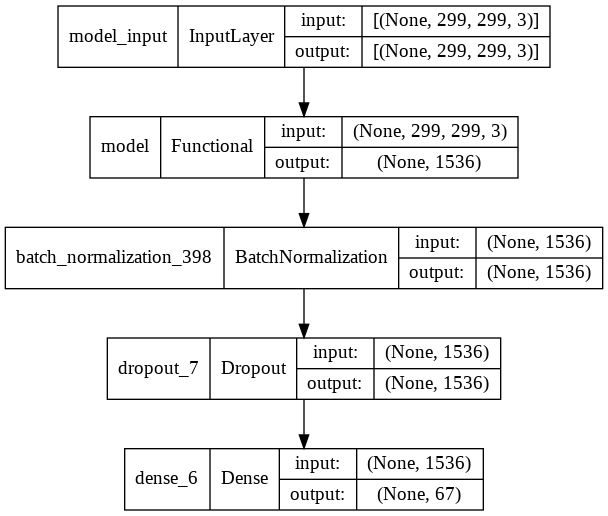

In [20]:
from tensorflow.keras.utils import plot_model

plot_model(best_model, show_shapes = True)